# Challenge
* To find the factors that affect life expectancy, which factors increase the expected life and which factors decrease it.

### Load the Dataset:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

life_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


### Detecting problems with the data (missing values and outliers):
- nonsense values that seem to be stemmed from the data collection
- missing values
- outliers

In [2]:
# quick look to see if there is missing data
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

There is missing data and I can also see right of the bat that there are some spacing issues with the column names. That will cause headaches down the line when trying to call on rows and not knowing how many spaces are before or after the name. Best to fix that now and not worry about it later.

In [3]:
# fix column names with erroneous spacing
life_df = life_df.rename(columns={"Life expectancy ": "Life expectancy",
                                  "Measles ": "Measles",
                                  " BMI ": "BMI",
                                  "under-five deaths ": "under-five deaths",
                                  "Diphtheria ": "Diphtheria",
                                  " HIV/AIDS": "HIV/AIDS",
                                  " thinness  1-19 years": "thinness 1-19 years",
                                  " thinness 5-9 years": "thinness 5-9 years"})

In [4]:
# calculate the percentages of the missing values in all columns
print('Percentages of the Missing Values in all Columns:')
life_df.isnull().sum()*100/life_df.isnull().count()

Percentages of the Missing Values in all Columns:


Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
BMI                                 1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
HIV/AIDS                            0.000000
GDP                                15.248468
Population                         22.191967
thinness 1-19 years                 1.157250
thinness 5-9 years                  1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

All of the missing data falls into the continuous variable category so we should be able to handle most of it with interpolation.

In [5]:
missing_list = ['Life expectancy', 'Adult Mortality', 'Alcohol', 'Hepatitis B', 'BMI', 'Polio',
                'Total expenditure', 'Diphtheria', 'GDP', 'Population', 'thinness 1-19 years',
                'thinness 5-9 years', 'Income composition of resources',
                'Schooling']

countries = life_df['Country'].unique()

In [6]:
for country in countries:
    life_df.loc[life_df['Country'] == country, missing_list] = life_df.loc[life_df['Country'] == country, missing_list].interpolate()
    
# Drop remaining null values after interpolation.
life_df.dropna(inplace=True)

In [7]:
# calculate the percentages of the missing values in all columns
print('Percentages of the Missing Values in all Columns:')
life_df.isnull().sum()*100/life_df.isnull().count()

Percentages of the Missing Values in all Columns:


Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
BMI                                0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
HIV/AIDS                           0.0
GDP                                0.0
Population                         0.0
thinness 1-19 years                0.0
thinness 5-9 years                 0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64

Now that we have taken care of the missing data, lets see if we have any outliers

In [8]:
life_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.00000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000,1987.000000
mean,2006.984902,67.981782,175.187217,36.623553,4.455644,685.492318,73.86160,2729.561651,36.428636,50.932562,80.371917,5.902728,80.454454,2.274937,5392.335709,1.358390e+07,5.129995,5.199346,0.603453,11.639054
std,4.323147,9.706401,131.616942,138.784913,3.976733,1761.669050,29.02807,12102.389143,19.736138,188.933117,24.363376,2.287467,24.450153,6.005112,11480.810350,6.490113e+07,4.750149,4.844382,0.206026,3.212964
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,2.00000,0.000000,1.400000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2003.000000,61.700000,75.000000,1.000000,0.830000,29.469887,64.00000,0.000000,18.150000,1.000000,74.000000,4.360000,75.500000,0.100000,384.553107,1.967480e+05,1.600000,1.600000,0.473000,9.700000
50%,2007.000000,69.900000,153.000000,4.000000,3.770000,104.314473,86.00000,20.000000,38.700000,4.000000,91.000000,5.800000,91.000000,0.100000,1334.651896,1.396861e+06,3.300000,3.400000,0.648000,11.900000
75%,2011.000000,74.700000,243.000000,25.000000,7.190000,470.870122,95.00000,499.500000,55.000000,36.000000,96.000000,7.385000,96.000000,1.400000,4441.530655,7.625918e+06,7.600000,7.700000,0.745000,13.700000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,18961.348600,99.00000,212183.000000,77.100000,2500.000000,99.000000,14.390000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.936000,20.700000


In [9]:
column_list = []

for column in life_df:
    column_list.append(column)

#list without first 3 columns
column_list2 = column_list[3:]

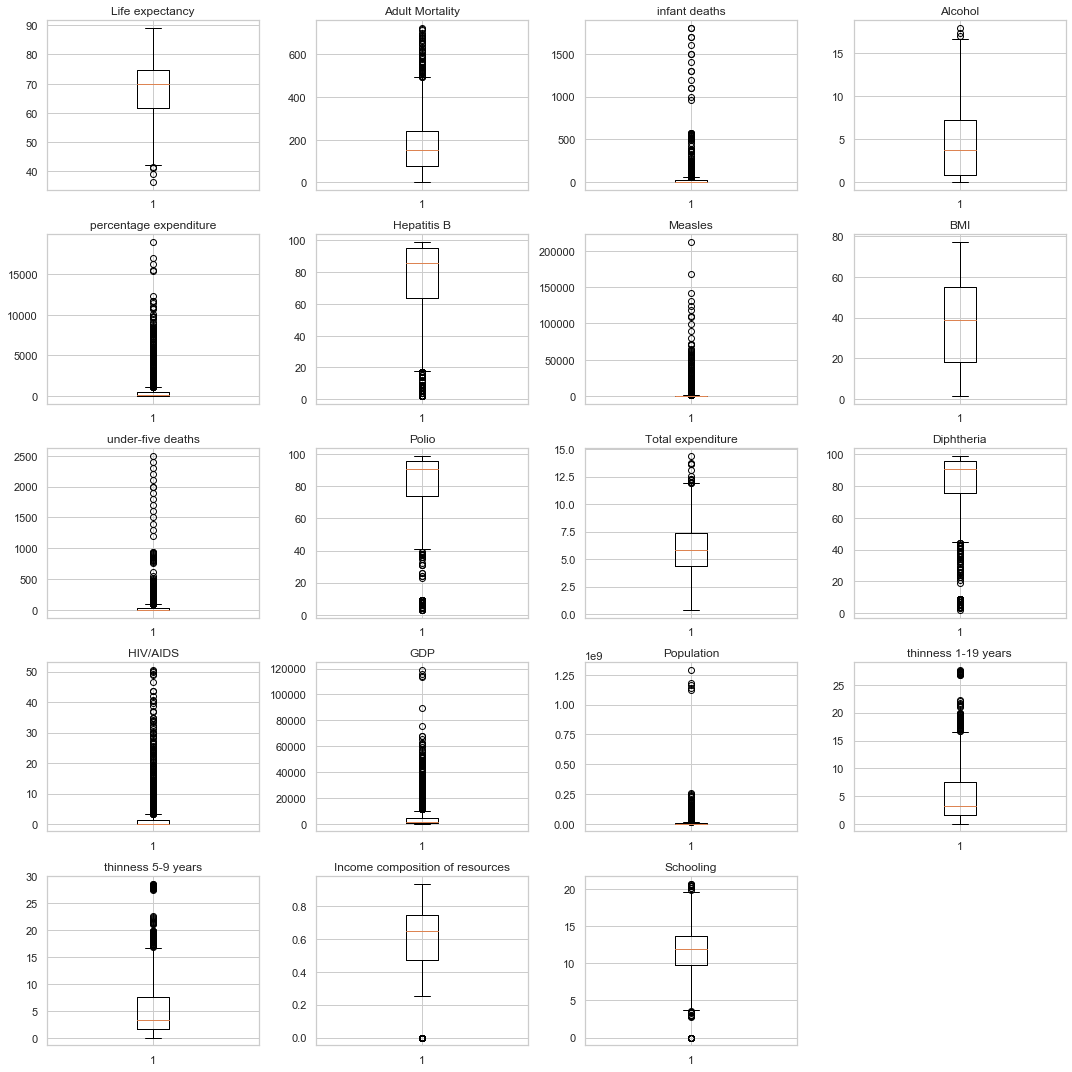

In [10]:
# Visual Detection Method
plt.figure(figsize = (15,15))

for column in column_list[3:]:
    index = column_list[3:].index(column) + 1
    try:
        plt.subplot(5,4,index)
        plt.boxplot(life_df[column])
        plt.title(column)
    except ValueError:
        pass

plt.tight_layout()

plt.show()

In [11]:
#Number of Outliers per column

for column in column_list[3:]:
    # Tukey's method
    q75, q25 = np.percentile(life_df[column], [75 ,25])
    iqr = q75 - q25
    print(20 * '=')
    print(column + ' Outliers:')
    print(20 * '=')
    for threshold in np.arange(1,5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        print("The score threshold is: {}".format(threshold))
        print("Number of outliers is: {}".format(
            len((np.where((life_df[column] > max_val) | (life_df[column] < min_val))[0]))))
        print("Percentage of outliers is: {}".format(
            ((len((np.where((life_df[column] > max_val) | (life_df[column] < min_val))[0])))/2938)*100))
    print('\n')

Life expectancy Outliers:
The score threshold is: 1.0
Number of outliers is: 106
Percentage of outliers is: 3.6078965282505107
The score threshold is: 1.5
Number of outliers is: 4
Percentage of outliers is: 0.13614703880190604
The score threshold is: 2.0
Number of outliers is: 0
Percentage of outliers is: 0.0
The score threshold is: 2.5
Number of outliers is: 0
Percentage of outliers is: 0.0
The score threshold is: 3.0
Number of outliers is: 0
Percentage of outliers is: 0.0
The score threshold is: 3.5
Number of outliers is: 0
Percentage of outliers is: 0.0
The score threshold is: 4.0
Number of outliers is: 0
Percentage of outliers is: 0.0
The score threshold is: 4.5
Number of outliers is: 0
Percentage of outliers is: 0.0


Adult Mortality Outliers:
The score threshold is: 1.0
Number of outliers is: 119
Percentage of outliers is: 4.050374404356705
The score threshold is: 1.5
Number of outliers is: 58
Percentage of outliers is: 1.9741320626276377
The score threshold is: 2.0
Number of out

Number of outliers is: 177
Percentage of outliers is: 6.024506466984343
The score threshold is: 3.5
Number of outliers is: 163
Percentage of outliers is: 5.547991831177672
The score threshold is: 4.0
Number of outliers is: 153
Percentage of outliers is: 5.207624234172907
The score threshold is: 4.5
Number of outliers is: 140
Percentage of outliers is: 4.765146358066712


thinness 1-19 years Outliers:
The score threshold is: 1.0
Number of outliers is: 119
Percentage of outliers is: 4.050374404356705
The score threshold is: 1.5
Number of outliers is: 70
Percentage of outliers is: 2.382573179033356
The score threshold is: 2.0
Number of outliers is: 27
Percentage of outliers is: 0.9189925119128658
The score threshold is: 2.5
Number of outliers is: 15
Percentage of outliers is: 0.5105513955071478
The score threshold is: 3.0
Number of outliers is: 15
Percentage of outliers is: 0.5105513955071478
The score threshold is: 3.5
Number of outliers is: 0
Percentage of outliers is: 0.0
The score thr

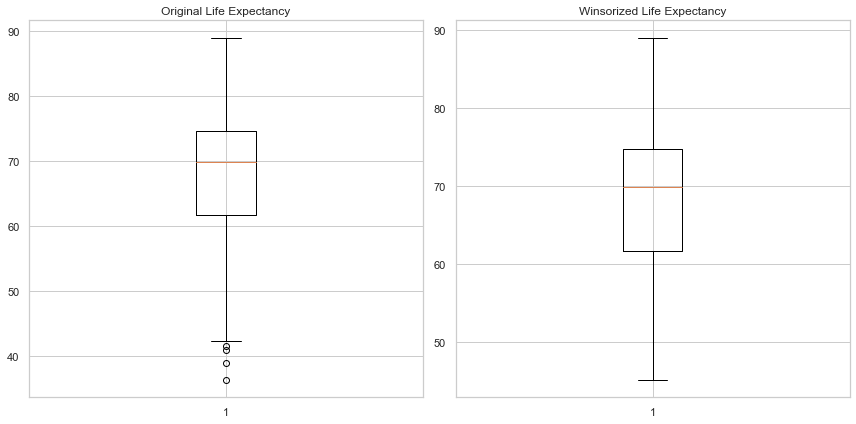

In [13]:
# apply winsorization
win_dict = {}

# Life expectancy
plt.figure(figsize = (12, 6))

original_life_expectancy = life_df['Life expectancy']
plt.subplot(1,2,1)
plt.boxplot(original_life_expectancy)
plt.title('Original Life Expectancy')

winsorized_life_expectancy = winsorize(life_df['Life expectancy'], (0.01, 0))
plt.subplot(1,2,2)
plt.boxplot(winsorized_life_expectancy)
plt.title('Winsorized Life Expectancy')

plt.tight_layout()
plt.show()

win_dict['win life exp'] = winsorized_life_expectancy

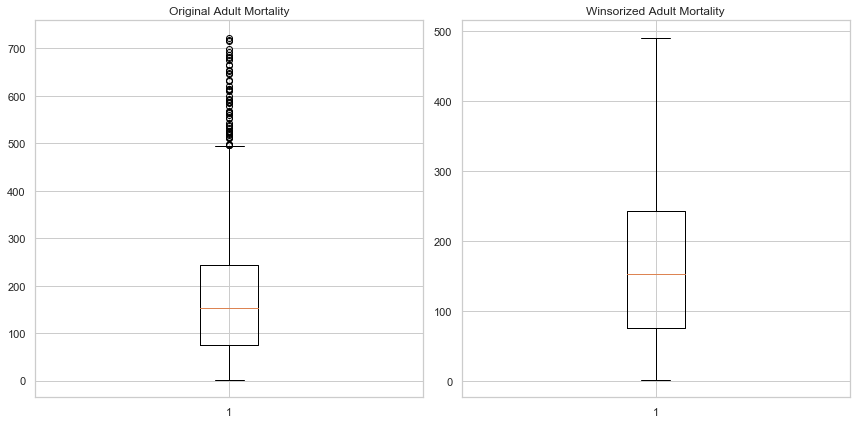

In [14]:
# Adult Mortality
plt.figure(figsize = (12, 6))

original_adult_mortality = life_df['Adult Mortality']
plt.subplot(1,2,1)
plt.boxplot(original_adult_mortality)
plt.title('Original Adult Mortality')

winsorized_adult_mortality = winsorize(life_df['Adult Mortality'], (0, 0.03))
plt.subplot(1,2,2)
plt.boxplot(winsorized_adult_mortality)
plt.title('Winsorized Adult Mortality')

plt.tight_layout()
plt.show()

win_dict['win adult mortality'] = winsorized_adult_mortality

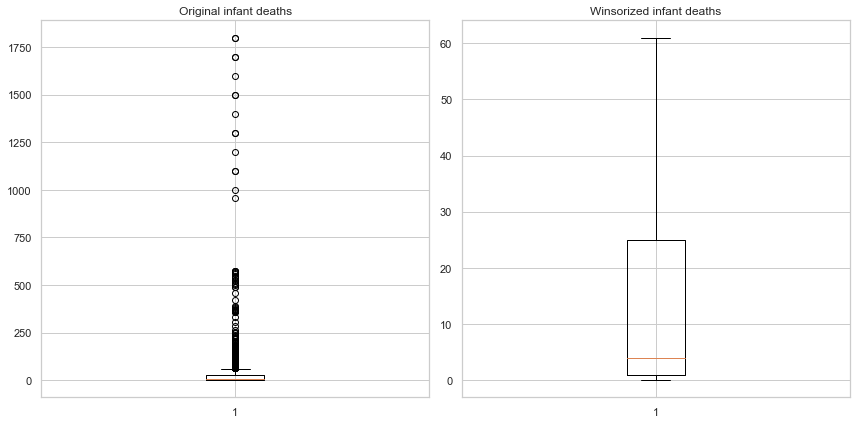

In [15]:
# infant deaths
plt.figure(figsize = (12, 6))

original_infant_deaths = life_df['infant deaths']
plt.subplot(1,2,1)
plt.boxplot(original_infant_deaths)
plt.title('Original infant deaths')

winsorized_infant_deaths = winsorize(life_df['infant deaths'], (0, 0.10))
plt.subplot(1,2,2)
plt.boxplot(winsorized_infant_deaths)
plt.title('Winsorized infant deaths')

plt.tight_layout()
plt.show()

win_dict['win infant deaths'] = winsorized_infant_deaths

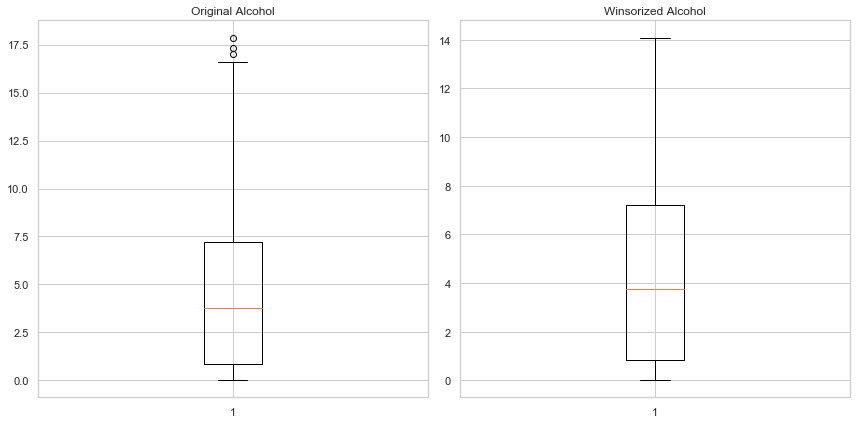

In [16]:
# Alcohol
plt.figure(figsize = (12, 6))

original_alcohol = life_df['Alcohol']
plt.subplot(1,2,1)
plt.boxplot(original_alcohol)
plt.title('Original Alcohol')

winsorized_alcohol = winsorize(life_df['Alcohol'], (0, 0.01))
plt.subplot(1,2,2)
plt.boxplot(winsorized_alcohol)
plt.title('Winsorized Alcohol')

plt.tight_layout()
plt.show()

win_dict['win alcohol'] = winsorized_alcohol

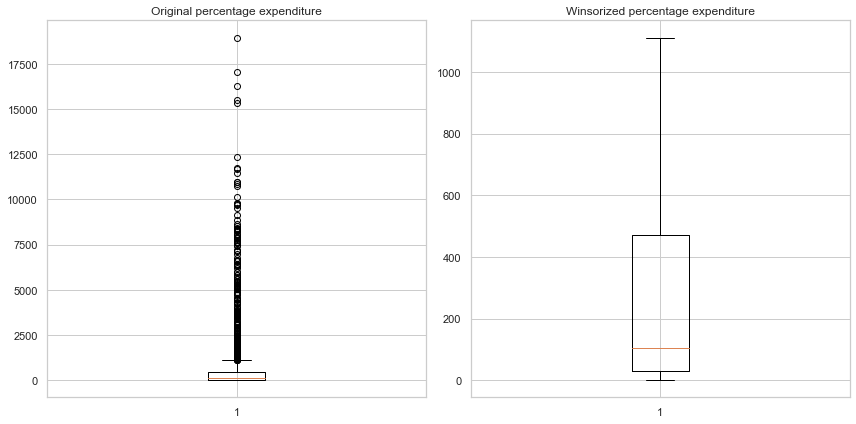

In [17]:
# percentage expenditure
plt.figure(figsize = (12, 6))

original_percentage_expenditure = life_df['percentage expenditure']
plt.subplot(1,2,1)
plt.boxplot(original_percentage_expenditure)
plt.title('Original percentage expenditure')

winsorized_percentage_expenditure = winsorize(life_df['percentage expenditure'], (0, 0.12))
plt.subplot(1,2,2)
plt.boxplot(winsorized_percentage_expenditure)
plt.title('Winsorized percentage expenditure')

plt.tight_layout()
plt.show()

win_dict['win percentage exp'] = winsorized_percentage_expenditure

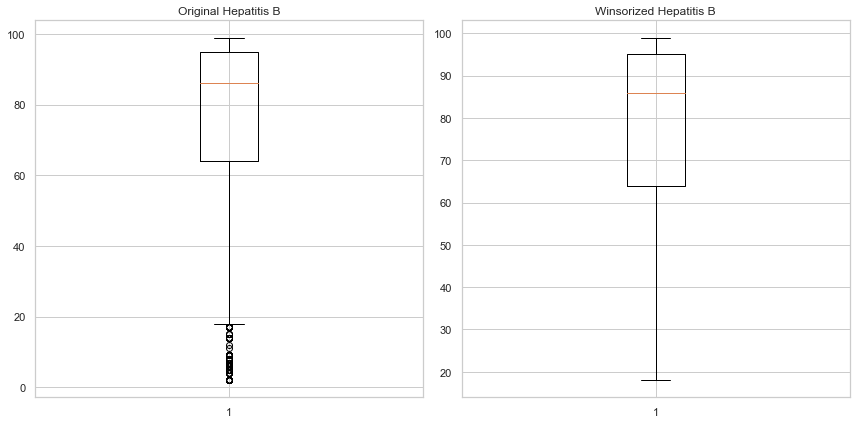

In [18]:
# Hepatitis B
plt.figure(figsize = (12, 6))

original_hepatitis_b = life_df['Hepatitis B']
plt.subplot(1,2,1)
plt.boxplot(original_hepatitis_b)
plt.title('Original Hepatitis B')

winsorized_hepatitis_b = winsorize(life_df['Hepatitis B'], (0.11, 0))
plt.subplot(1,2,2)
plt.boxplot(winsorized_hepatitis_b)
plt.title('Winsorized Hepatitis B')

plt.tight_layout()
plt.show()

win_dict['win hep b'] = winsorized_hepatitis_b

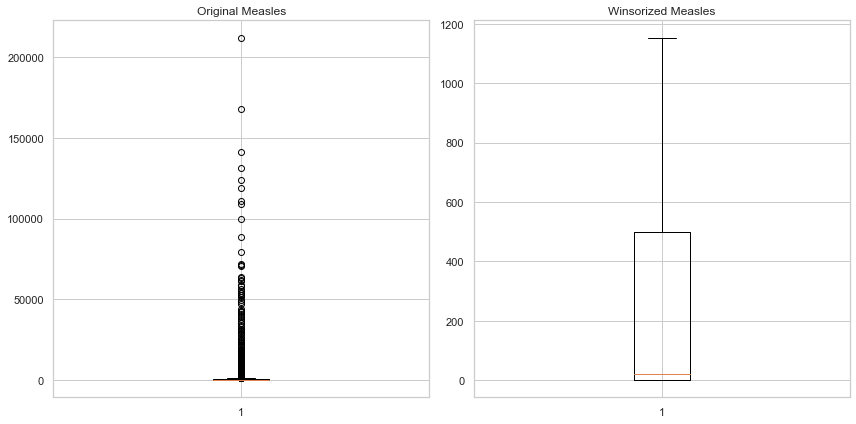

In [19]:
# Measles
plt.figure(figsize = (12, 6))

original_measles = life_df['Measles']
plt.subplot(1,2,1)
plt.boxplot(original_measles)
plt.title('Original Measles')

winsorized_measles = winsorize(life_df['Measles'], (0, 0.19))
plt.subplot(1,2,2)
plt.boxplot(winsorized_measles)
plt.title('Winsorized Measles')

plt.tight_layout()
plt.show()

win_dict['win measles'] = winsorized_measles

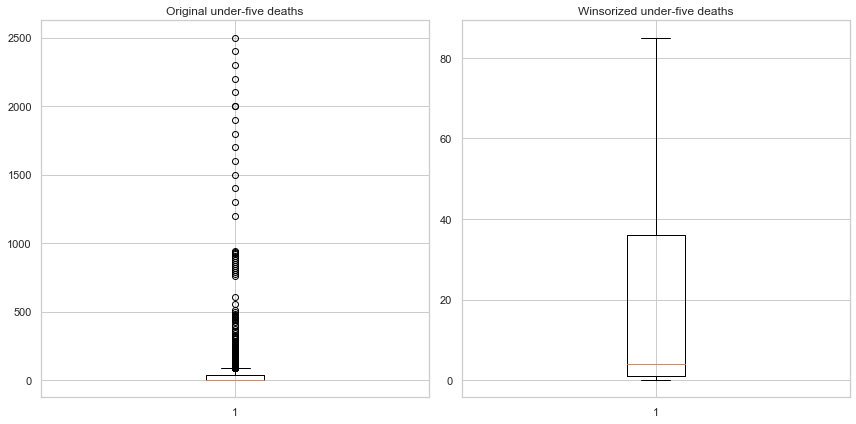

In [20]:
# under-five deaths
plt.figure(figsize = (12, 6))

original_under_five_deaths = life_df['under-five deaths']
plt.subplot(1,2,1)
plt.boxplot(original_under_five_deaths)
plt.title('Original under-five deaths')

winsorized_under_five_deaths = winsorize(life_df['under-five deaths'], (0, 0.12))
plt.subplot(1,2,2)
plt.boxplot(winsorized_under_five_deaths)
plt.title('Winsorized under-five deaths')

plt.tight_layout()
plt.show()

win_dict['win under-5 deaths'] = winsorized_under_five_deaths

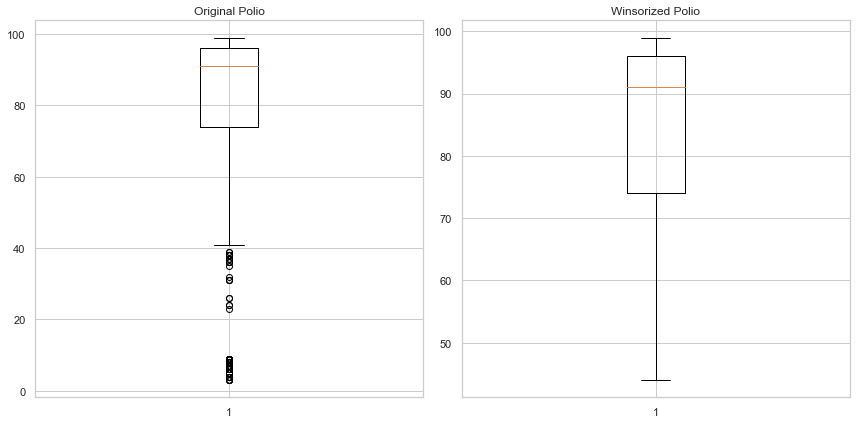

In [21]:
# Polio
plt.figure(figsize = (12, 6))

original_polio = life_df['Polio']
plt.subplot(1,2,1)
plt.boxplot(original_polio)
plt.title('Original Polio')

winsorized_polio = winsorize(life_df['Polio'], (0.09, 0))
plt.subplot(1,2,2)
plt.boxplot(winsorized_polio)
plt.title('Winsorized Polio')

plt.tight_layout()
plt.show()

win_dict['win polio'] = winsorized_polio

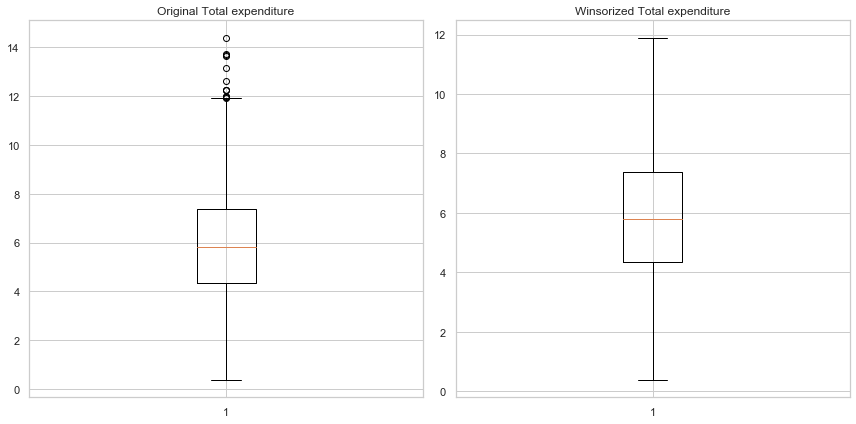

In [22]:
# Total expenditure
plt.figure(figsize = (12, 6))

original_total_expenditure = life_df['Total expenditure']
plt.subplot(1,2,1)
plt.boxplot(original_total_expenditure)
plt.title('Original Total expenditure')

winsorized_total_expenditure = winsorize(life_df['Total expenditure'], (0, 0.007))
plt.subplot(1,2,2)
plt.boxplot(winsorized_total_expenditure)
plt.title('Winsorized Total expenditure')

plt.tight_layout()
plt.show()

win_dict['win total exp'] = winsorized_total_expenditure

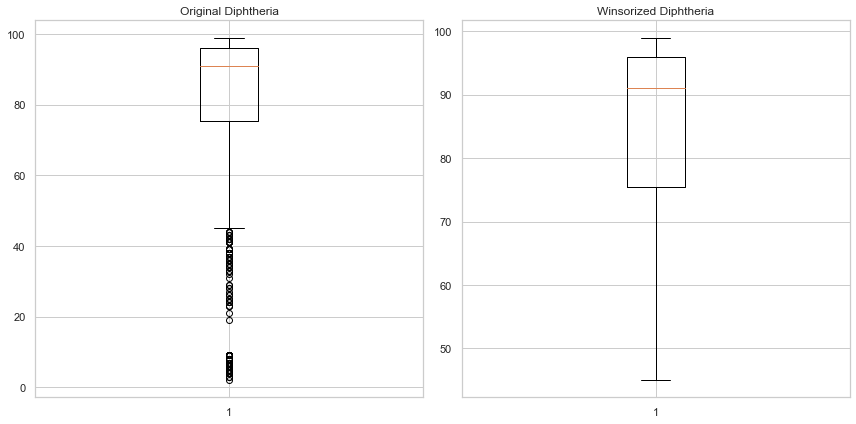

In [23]:
# Diphtheria
plt.figure(figsize = (12, 6))

original_diphtheria = life_df['Diphtheria']
plt.subplot(1,2,1)
plt.boxplot(original_diphtheria)
plt.title('Original Diphtheria')

winsorized_diphtheria = winsorize(life_df['Diphtheria'], (0.1, 0))
plt.subplot(1,2,2)
plt.boxplot(winsorized_diphtheria)
plt.title('Winsorized Diphtheria')

plt.tight_layout()
plt.show()

win_dict['win diphtheria'] = winsorized_diphtheria

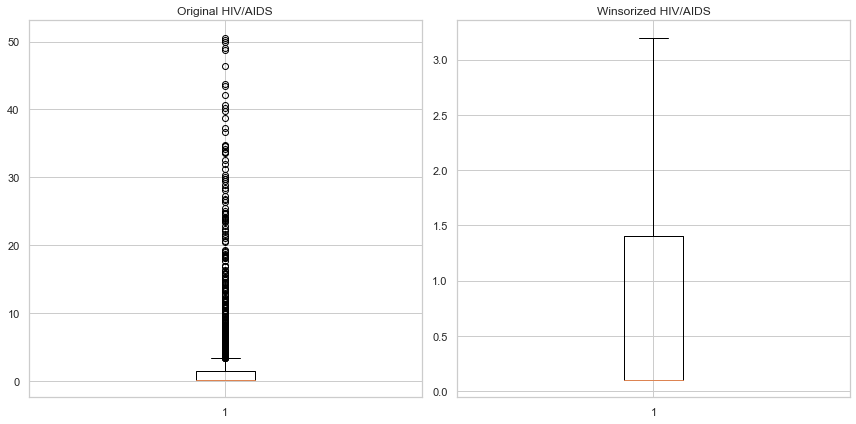

In [24]:
# HIV/AIDS
plt.figure(figsize = (12, 6))

original_hiv_aids = life_df['HIV/AIDS']
plt.subplot(1,2,1)
plt.boxplot(original_hiv_aids)
plt.title('Original HIV/AIDS')

winsorized_hiv_aids = winsorize(life_df['HIV/AIDS'], (0, 0.16))
plt.subplot(1,2,2)
plt.boxplot(winsorized_hiv_aids)
plt.title('Winsorized HIV/AIDS')

plt.tight_layout()
plt.show()

win_dict['win hiv'] = winsorized_hiv_aids

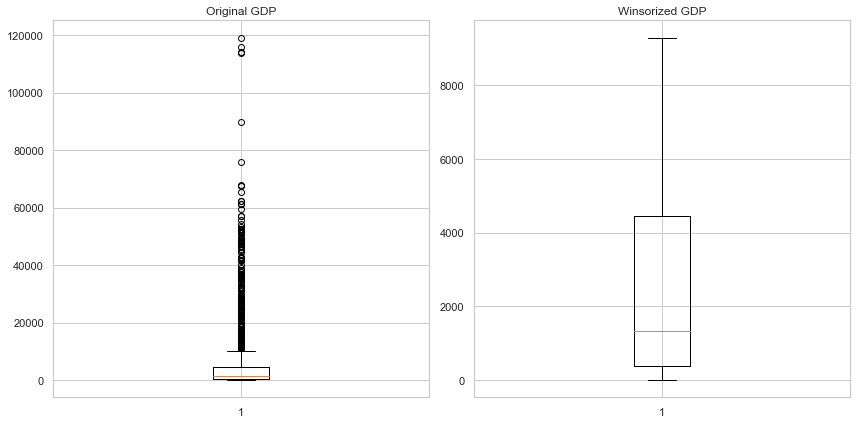

In [25]:
# GDP
plt.figure(figsize = (12, 6))

original_gdp = life_df['GDP']
plt.subplot(1,2,1)
plt.boxplot(original_gdp)
plt.title('Original GDP')

winsorized_gdp = winsorize(life_df['GDP'], (0, 0.13))
plt.subplot(1,2,2)
plt.boxplot(winsorized_gdp)
plt.title('Winsorized GDP')

plt.tight_layout()
plt.show()

win_dict['win gdp'] = winsorized_gdp

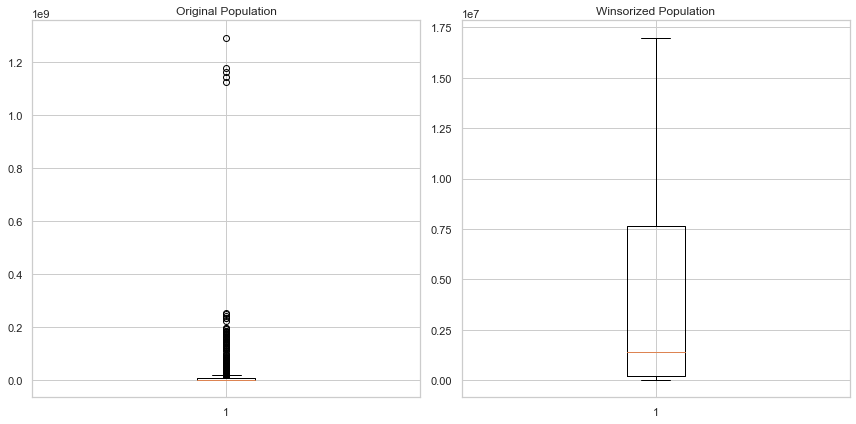

In [26]:
# Population
plt.figure(figsize = (12, 6))

original_population = life_df['Population']
plt.subplot(1,2,1)
plt.boxplot(original_population)
plt.title('Original Population')

winsorized_population = winsorize(life_df['Population'], (0, 0.14))
plt.subplot(1,2,2)
plt.boxplot(winsorized_population)
plt.title('Winsorized Population')

plt.tight_layout()
plt.show()

win_dict['win pop'] = winsorized_population

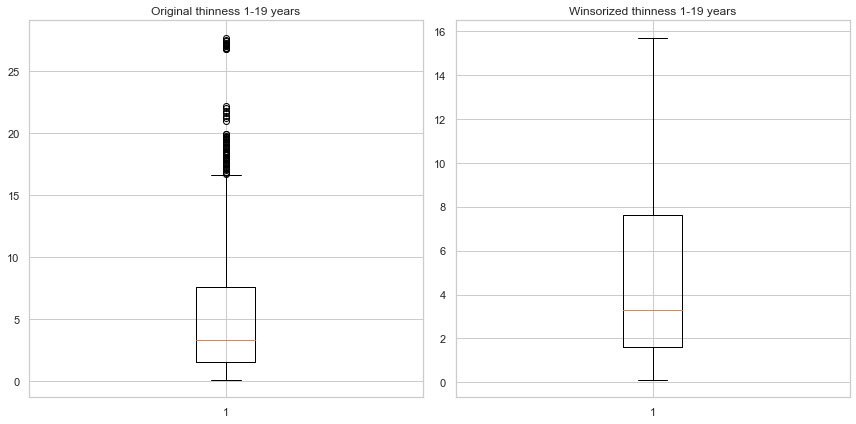

In [27]:
# thinness 1-19 years
plt.figure(figsize = (12, 6))

original_thinness_1_19_years = life_df['thinness 1-19 years']
plt.subplot(1,2,1)
plt.boxplot(original_thinness_1_19_years)
plt.title('Original thinness 1-19 years')

winsorized_thinness_1_19_years = winsorize(life_df['thinness 1-19 years'], (0, 0.04))
plt.subplot(1,2,2)
plt.boxplot(winsorized_thinness_1_19_years)
plt.title('Winsorized thinness 1-19 years')

plt.tight_layout()
plt.show()

win_dict['win thin 1-19'] = winsorized_thinness_1_19_years

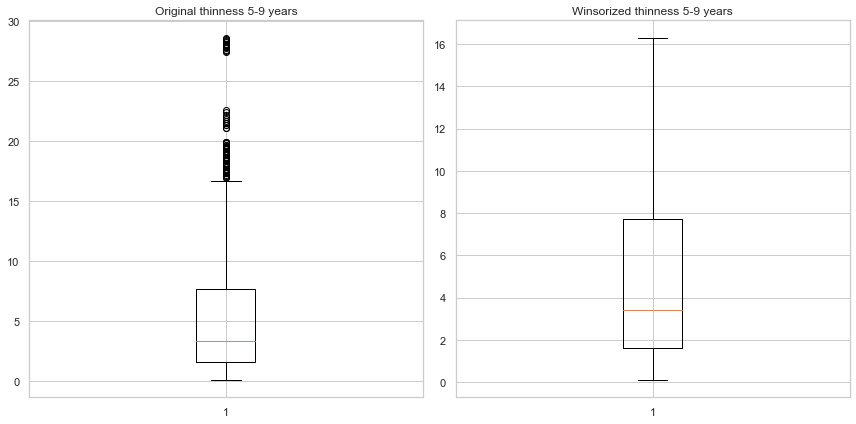

In [28]:
# thinness 5-9 years
plt.figure(figsize = (12, 6))

original_thinness_5_9_years = life_df['thinness 5-9 years']
plt.subplot(1,2,1)
plt.boxplot(original_thinness_5_9_years)
plt.title('Original thinness 5-9 years')

winsorized_thinness_5_9_years = winsorize(life_df['thinness 5-9 years'], (0, 0.04))
plt.subplot(1,2,2)
plt.boxplot(winsorized_thinness_5_9_years)
plt.title('Winsorized thinness 5-9 years')

plt.tight_layout()
plt.show()

win_dict['win thin 5-9'] = winsorized_thinness_5_9_years

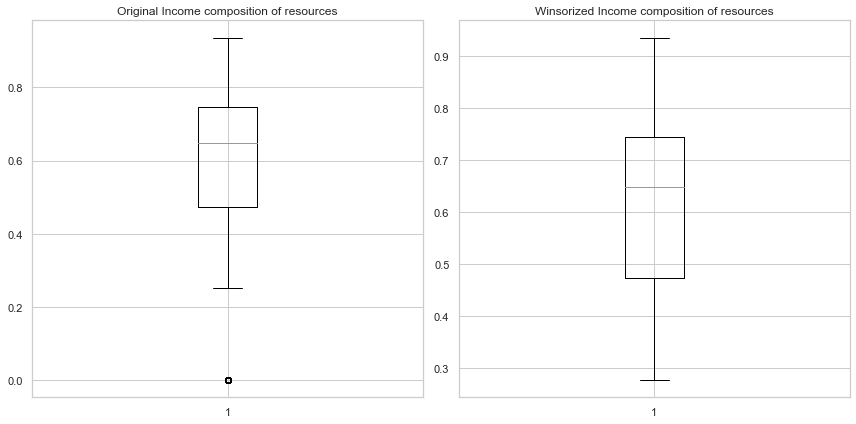

In [29]:
# Income composition of resources
plt.figure(figsize = (12, 6))

original_income_composition_of_resources = life_df['Income composition of resources']
plt.subplot(1,2,1)
plt.boxplot(original_income_composition_of_resources)
plt.title('Original Income composition of resources')

winsorized_income_composition_of_resources = winsorize(life_df['Income composition of resources'], (0.05, 0))
plt.subplot(1,2,2)
plt.boxplot(winsorized_income_composition_of_resources)
plt.title('Winsorized Income composition of resources')

plt.tight_layout()
plt.show()

win_dict['win income'] = winsorized_income_composition_of_resources

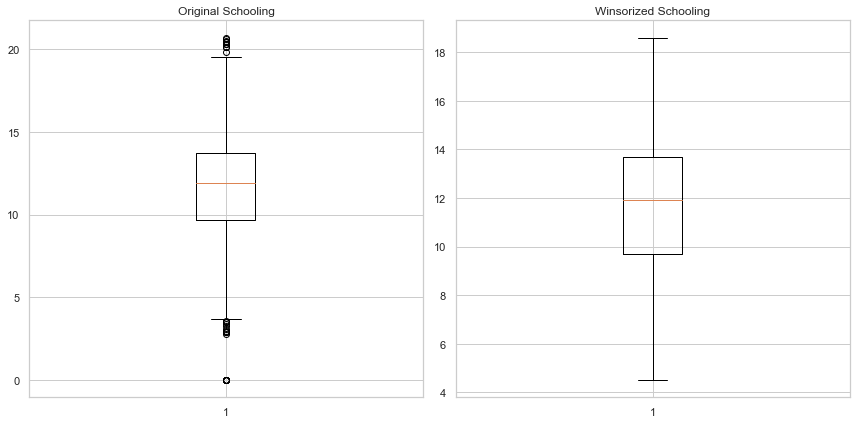

In [30]:
# Schooling
plt.figure(figsize = (12, 6))

original_schooling = life_df['Schooling']
plt.subplot(1,2,1)
plt.boxplot(original_schooling)
plt.title('Original Schooling')

winsorized_schooling = winsorize(life_df['Schooling'], (0.02, 0.01))
plt.subplot(1,2,2)
plt.boxplot(winsorized_schooling)
plt.title('Winsorized Schooling')

plt.tight_layout()
plt.show()

win_dict['win schooling'] = winsorized_schooling

In [31]:
# Winsorized features

life_df['win life exp'] = winsorized_life_expectancy
life_df['win adult mortality'] = winsorized_adult_mortality
life_df['win infant deaths'] = winsorized_infant_deaths
life_df['win alcohol'] = winsorized_alcohol
life_df['win percentage exp'] = winsorized_percentage_expenditure
life_df['win hep b'] = winsorized_hepatitis_b
life_df['win measles'] = winsorized_measles 
life_df['win under-5 deaths'] = winsorized_under_five_deaths
life_df['win polio'] = winsorized_polio
life_df['win total exp'] = winsorized_total_expenditure
life_df['win diphtheria'] = winsorized_diphtheria
life_df['win hiv'] = winsorized_hiv_aids
life_df['win gdp'] = winsorized_gdp
life_df['win pop'] = winsorized_population
life_df['win thin 1-19'] = winsorized_thinness_1_19_years
life_df['win thin 5-9'] = winsorized_thinness_5_9_years
life_df['win income'] = winsorized_income_composition_of_resources
life_df['win schooling'] = winsorized_schooling

### Exploration of the data using univariate and multivariate exploration techniques.
Paying special attention to the target variable. Focusing on finding the relevant variables that may affect life expectancy.

In [32]:
win_list = list(win_dict.keys())

new_col = ['Country', 'Year', 'Status', 'Life expectancy', 'win life exp', 'Adult Mortality', 
            'win adult mortality', 'infant deaths', 'win infant deaths', 'Alcohol', 'win alcohol', 
            'percentage expenditure', 'win percentage exp', 'Hepatitis B', 'win hep b', 'Measles',
            'win measles', 'BMI', 'BMI', 'under-five deaths', 'win under-5 deaths', 'Polio', 'win polio', 
            'Total expenditure', 'win total exp', 'Diphtheria', 'win diphtheria', 'HIV/AIDS', 'win hiv', 
            'GDP', 'win gdp', 'Population', 'win pop', 'thinness 1-19 years', 'win thin 1-19', 
            'thinness 5-9 years', 'win thin 5-9', 'Income composition of resources', 'win income', 
            'Schooling', 'win schooling']

life_df2 = life_df[['Country', 'Year', 'Status', 'Life expectancy', 'win life exp', 'Adult Mortality', 
            'win adult mortality', 'infant deaths', 'win infant deaths', 'Alcohol', 'win alcohol', 
            'percentage expenditure', 'win percentage exp', 'Hepatitis B', 'win hep b', 'Measles',
            'win measles', 'BMI', 'under-five deaths', 'win under-5 deaths', 'Polio', 'win polio', 
            'Total expenditure', 'win total exp', 'Diphtheria', 'win diphtheria', 'HIV/AIDS', 'win hiv', 
            'GDP', 'win gdp', 'Population', 'win pop', 'thinness 1-19 years', 'win thin 1-19', 
            'thinness 5-9 years', 'win thin 5-9', 'Income composition of resources', 'win income', 
            'Schooling', 'win schooling']]

In [33]:
life_df2.describe()

,Year,Life expectancy,win life exp,Adult Mortality,win adult mortality,infant deaths,win infant deaths,Alcohol,win alcohol,percentage expenditure,...,Population,win pop,thinness 1-19 years,win thin 1-19,thinness 5-9 years,win thin 5-9,Income composition of resources,win income,Schooling,win schooling
count,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,...,1.987000e+03,1.987000e+03,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000
mean,2006.984902,67.981782,68.000956,175.187217,172.334172,36.623553,15.502265,4.455644,4.443566,685.492318,...,1.358390e+07,4.799769e+06,5.129995,4.955561,5.199346,5.024006,0.603453,0.616143,11.639054,11.658581
std,4.323147,9.706401,9.656676,131.616942,122.914052,138.784913,20.877993,3.976733,3.943939,1761.669050,...,6.490113e+07,6.217060e+06,4.750149,4.187776,4.844382,4.265385,0.206026,0.174584,3.212964,3.102260
min,2000.000000,36.300000,45.100000,1.000000,1.000000,0.000000,0.000000,0.010000,0.010000,0.000000,...,3.400000e+01,3.400000e+01,0.100000,0.100000,0.100000,0.100000,0.000000,0.276000,0.000000,4.500000
25%,2003.000000,61.700000,61.700000,75.000000,75.000000,1.000000,1.000000,0.830000,0.830000,29.469887,...,1.967480e+05,1.967480e+05,1.600000,1.600000,1.600000,1.600000,0.473000,0.473000,9.700000,9.700000
50%,2007.000000,69.900000,69.900000,153.000000,153.000000,4.000000,4.000000,3.770000,3.770000,104.314473,...,1.396861e+06,1.396861e+06,3.300000,3.300000,3.400000,3.400000,0.648000,0.648000,11.900000,11.900000
75%,2011.000000,74.700000,74.700000,243.000000,243.000000,25.000000,25.000000,7.190000,7.190000,470.870122,...,7.625918e+06,7.625918e+06,7.600000,7.600000,7.700000,7.700000,0.745000,0.745000,13.700000,13.700000
max,2015.000000,89.000000,89.000000,723.000000,491.000000,1800.000000,61.000000,17.870000,14.090000,18961.348600,...,1.293859e+09,1.699335e+07,27.700000,15.700000,28.600000,16.300000,0.936000,0.936000,20.700000,18.600000


In [34]:
life_df2.describe(include=['O'])

,Country,Status
count,1987,1987
unique,133,2
top,Afghanistan,Developing
freq,16,1702


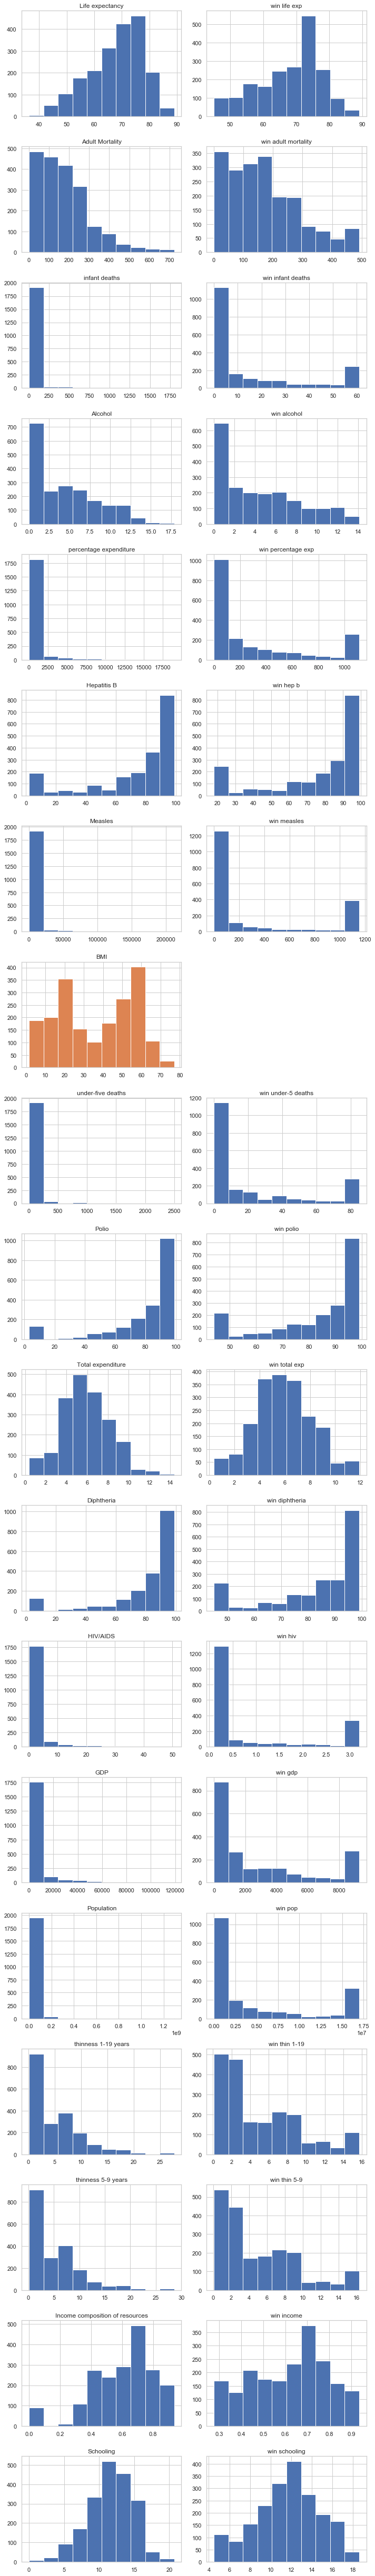

In [35]:
# histograms
plt.figure(figsize = (10,75))
for column in new_col[3:]:
    index = new_col[3:].index(column) + 1
    plt.subplot(21,2,index)
    plt.hist(life_df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

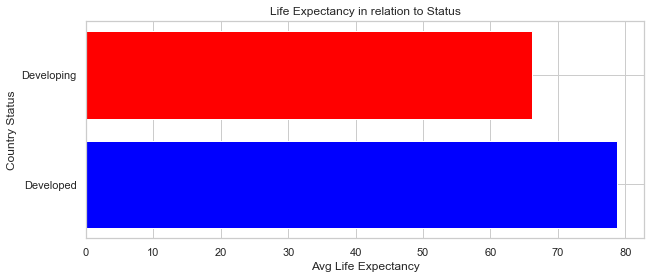

In [36]:
# Life Expectancy in relation to Status
plt.figure(figsize=(10,4))
plt.barh(life_df2.groupby("Status")["Status"].count().index, 
        life_df2.groupby("Status")["win life exp"].mean(), 
        color=["blue","red"])
plt.xlabel("Avg Life Expectancy")
plt.ylabel("Country Status")
plt.title("Life Expectancy in relation to Status")

plt.show()

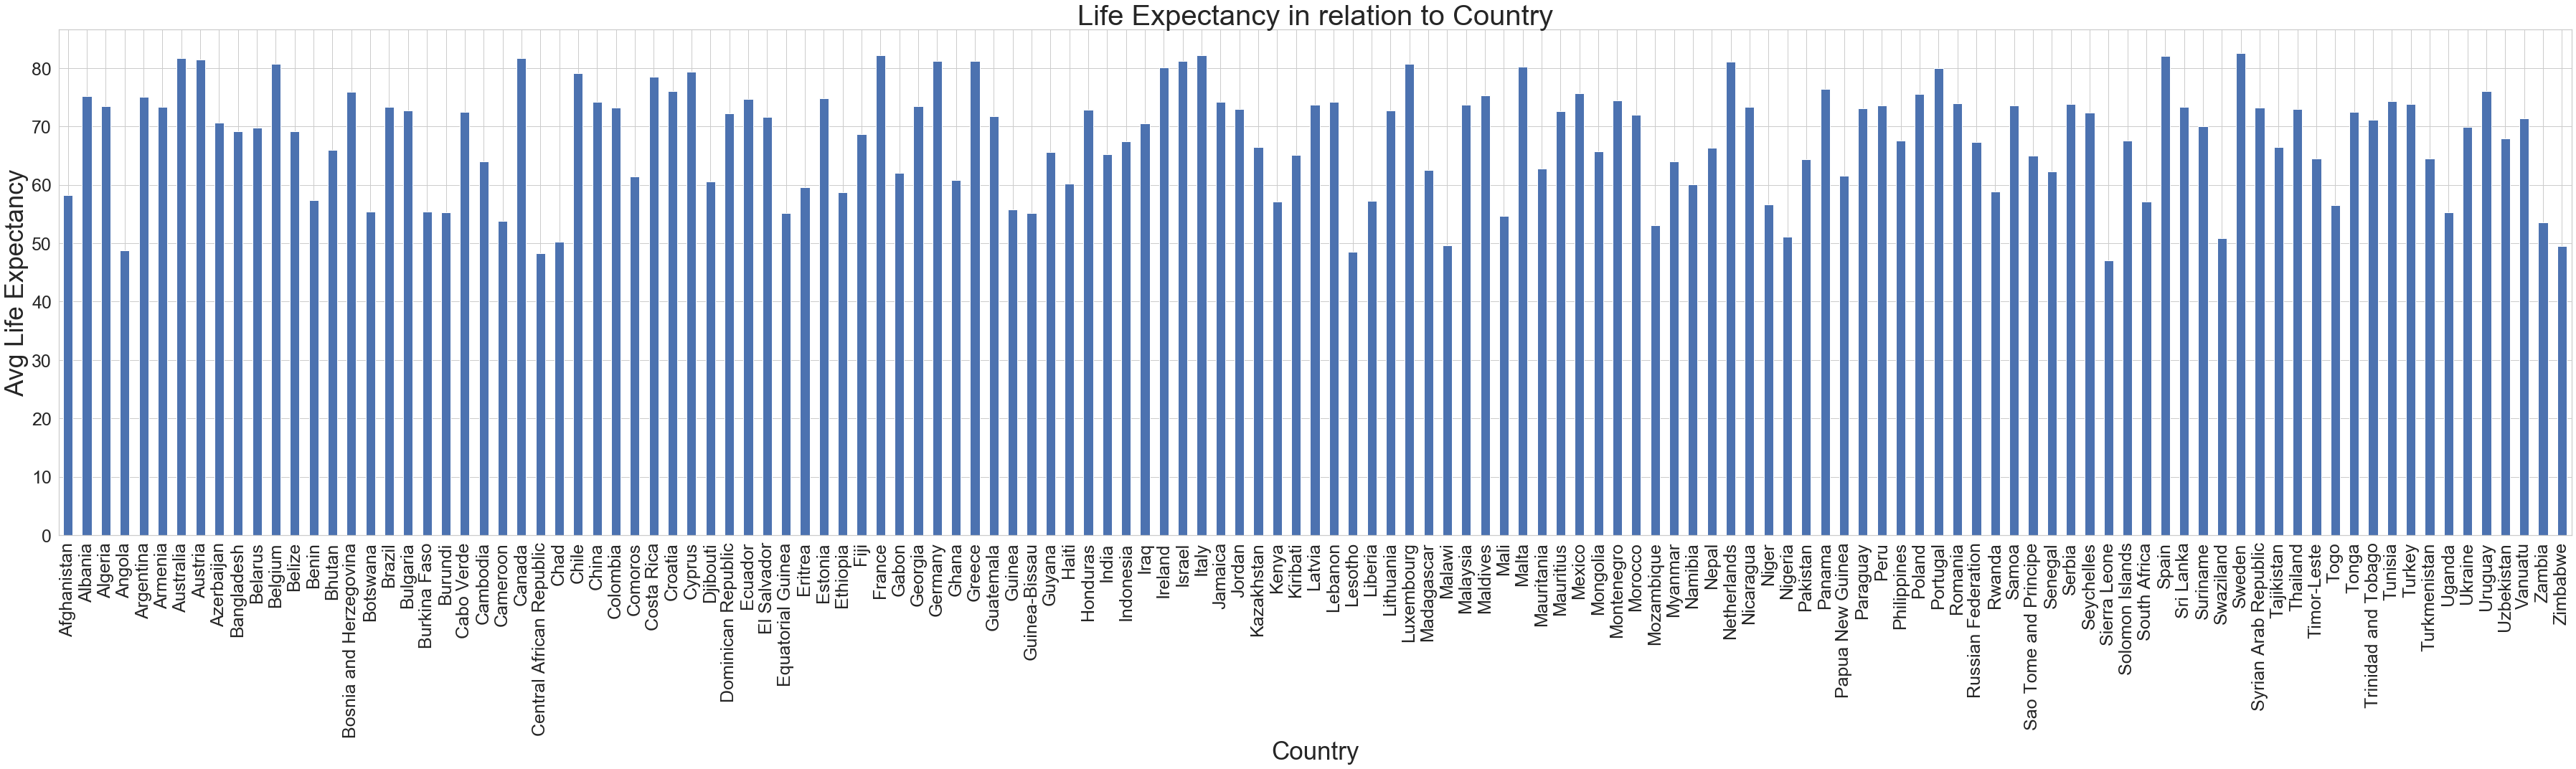

In [37]:
# Life Expectancy in relation to Country
life_exp_country = life_df2.groupby('Country')['win life exp'].mean()
life_exp_country.plot(kind='bar', figsize=(50,15), fontsize=25)
plt.title("Life Expectancy in relation to Country",fontsize=40)
plt.xlabel("Country",fontsize=35)
plt.ylabel("Avg Life Expectancy",fontsize=35)
plt.tight_layout()
plt.show()

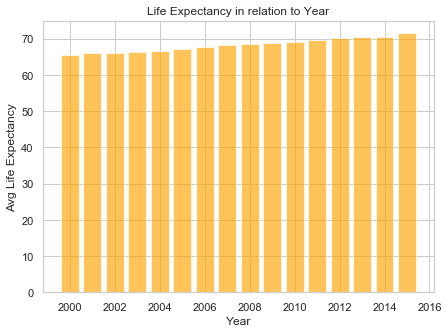

In [38]:
# Life Expectancy in relation to Year
plt.figure(figsize=(7,5))
plt.bar(life_df2.groupby('Year')['Year'].count().index,life_df2.groupby('Year')['win life exp'].mean(),color='orange',alpha=0.65)
plt.xlabel("Year",fontsize=12)
plt.ylabel("Avg Life Expectancy",fontsize=12)
plt.title("Life Expectancy in relation to Year")
plt.show()

In [41]:
win_list.append('BMI')

['win life exp',
 'win adult mortality',
 'win infant deaths',
 'win alcohol',
 'win percentage exp',
 'win hep b',
 'win measles',
 'win under-5 deaths',
 'win polio',
 'win total exp',
 'win diphtheria',
 'win hiv',
 'win gdp',
 'win pop',
 'win thin 1-19',
 'win thin 5-9',
 'win income',
 'win schooling',
 'BMI']

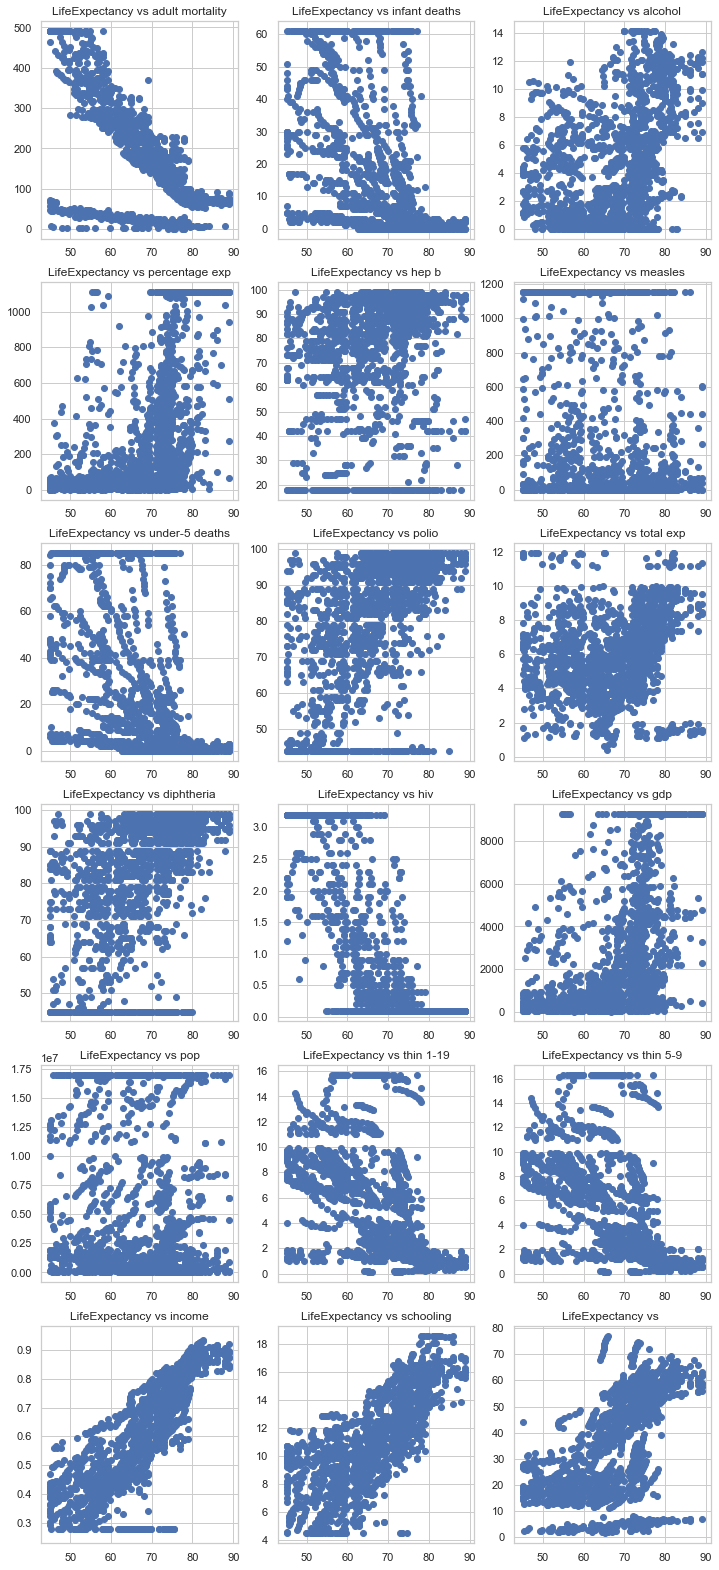

In [53]:
plt.figure(figsize=(12,28))

for col in win_list[1:]:
    index = win_list[1:].index(col) + 1
    plt.subplot(6,3,index)
    plt.scatter(life_df2["win life exp"], life_df2[col])
    plt.title("LifeExpectancy vs "+ col[4:])

plt.show()

In [55]:
life_df2[win_list].corr()

,win life exp,win adult mortality,win infant deaths,win alcohol,win percentage exp,win hep b,win measles,win under-5 deaths,win polio,win total exp,win diphtheria,win hiv,win gdp,win pop,win thin 1-19,win thin 5-9,win income,win schooling,BMI
win life exp,1.000000,-0.654255,-0.516494,0.396073,0.557117,0.268086,-0.313013,-0.552035,0.516167,0.207319,0.535687,-0.793696,0.551722,-0.040138,-0.507870,-0.498791,0.823222,0.762333,0.601434
win adult mortality,-0.654255,1.000000,0.303275,-0.191173,-0.313519,-0.113036,0.162011,0.325745,-0.275361,-0.113879,-0.274879,0.570475,-0.307826,0.045473,0.329845,0.335899,-0.488595,-0.429127,-0.384986
win infant deaths,-0.516494,0.303275,1.000000,-0.301196,-0.367645,-0.192581,0.585217,0.993583,-0.373281,-0.191875,-0.369402,0.362366,-0.355888,0.423702,0.412490,0.432688,-0.478552,-0.521371,-0.475304
win alcohol,0.396073,-0.191173,-0.301196,1.000000,0.535143,0.113096,-0.172897,-0.304476,0.280870,0.232277,0.289133,-0.139499,0.539202,0.004264,-0.417504,-0.406472,0.590256,0.599497,0.380291
win percentage exp,0.557117,-0.313519,-0.367645,0.535143,1.000000,0.097402,-0.228420,-0.375608,0.287148,0.286504,0.294386,-0.310117,0.915731,-0.027779,-0.392719,-0.391349,0.630088,0.613831,0.420946
win hep b,0.268086,-0.113036,-0.192581,0.113096,0.097402,1.000000,-0.212068,-0.204625,0.528167,0.132323,0.596233,-0.273668,0.130146,-0.057207,-0.155582,-0.166730,0.269518,0.282979,0.208182
win measles,-0.313013,0.162011,0.585217,-0.172897,-0.228420,-0.212068,1.000000,0.581067,-0.273715,-0.174928,-0.275367,0.186120,-0.218882,0.290223,0.346025,0.352841,-0.274875,-0.336212,-0.320338
win under-5 deaths,-0.552035,0.325745,0.993583,-0.304476,-0.375608,-0.204625,0.581067,1.000000,-0.394037,-0.187531,-0.391011,0.399829,-0.368849,0.403557,0.422059,0.438594,-0.509527,-0.549190,-0.495232
win polio,0.516167,-0.275361,-0.373281,0.280870,0.287148,0.528167,-0.273715,-0.394037,1.000000,0.183892,0.835268,-0.426480,0.313125,-0.043777,-0.268903,-0.265431,0.521442,0.528211,0.326339
win total exp,0.207319,-0.113879,-0.191875,0.232277,0.286504,0.132323,-0.174928,-0.187531,0.183892,1.000000,0.193764,-0.076190,0.216244,-0.095678,-0.245122,-0.262061,0.211392,0.265631,0.235684


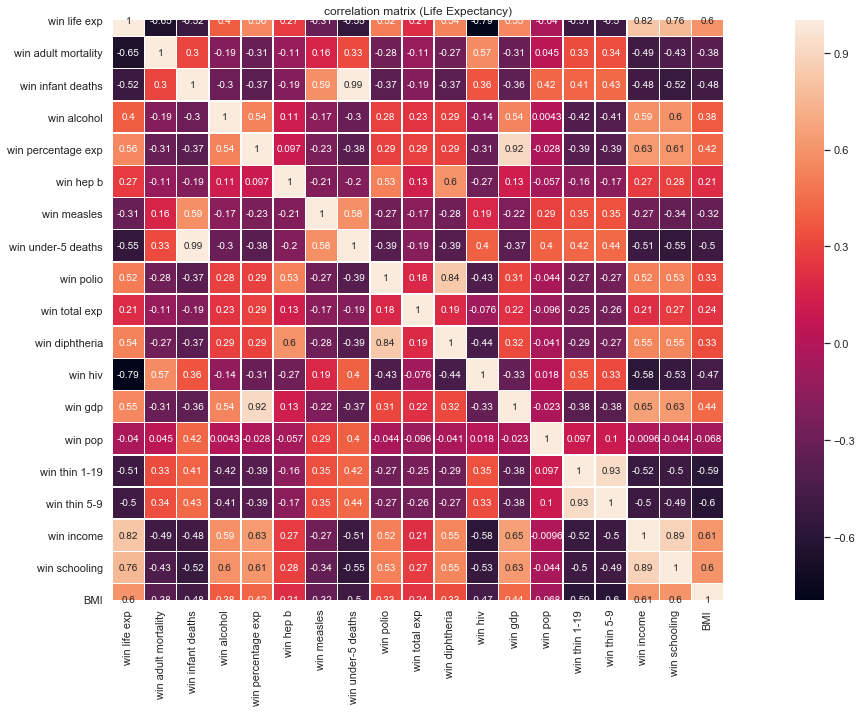

In [61]:
# make the correlation matrices.
corrmat_life_exp = life_df2[win_list].corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(20,10))

# draw the heatmap using seaborn.
sns.heatmap(corrmat_life_exp, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Life Expectancy)")
plt.tight_layout()
plt.show()


### Selecting a suite of variables that would be ideal in the modeling phase.

ideal variables:
- alcohol
- percentage exp
- measles
- under-5 deaths
- diphtheria
- hiv
- thin 1-19
- income
- schooling
- BMI

### Summary of Findings.

- Out of the 133 countries listed developed countries have a higher avergae life expectancy than developing countries.
- Life Expectancy across the board is increasing as time goes on.
- Several factors such as income and schooling may contribute to a longer life expectancy.